Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

In [13]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

house_prices <- source('main.R', local = TRUE)$value
num_tran <- house_prices$trans$numeric

combinedDataset <-
    house_prices$helpers$load_data() %>%
    (house_prices$outliers$remove_outliers) %>%
    (house_prices$missing$fix_all) %>%
    mutate(
        price_log = log(SalePrice),
        YrSold = as.character(YrSold),
        MoSold = as.character(MoSold)
    ) %>%
    select(-SalePrice)

test_that("should be no NA values except price_log column", {
    expect_equal(sum(is.na(combinedDataset %>% select(-price_log))), 0)
})

combinedDataset %>% dim %>% show_list

2917 82

In [8]:
transFn <- tribble(
    ~tran_name, ~tran_fn,
    'log',      function(x) log(x+1),
    'sqrt',     function(x) sqrt(x),
    'inv3',     function(x) x**(1/3),
    'inv4',     function(x) x**(1/4)
)

transformation_config <- 
   num_tran$Tran$get_transformation_config(
        dataset=combinedDataset %>% select(-price_log) %>% select_if(is.numeric),
        trans=transFn
    )
        
transformation_config2 <- 
    num_tran$Tran$get_transformation_config(
        dataset=combinedDataset %>% select(-price_log),
        trans=transFn
    )
        
test_that("should be equal", {
    expect_equal(
        transformation_config %>% select(-tran_fn), 
        transformation_config2 %>% select(-tran_fn)
    )
})

show_table(transformation_config, cols = 2)

var,tran_name,progress_score,tran_fn
GrLivArea,log,91.157942,"function (x) , log(x + 1)"
X1stFlrSF,log,90.771657,"function (x) , log(x + 1)"
BsmtUnfSF,sqrt,79.976031,"function (x) , sqrt(x)"
LotArea,inv4,78.864026,"function (x) , x^(1/4)"
TotRmsAbvGrd,log,30.685015,"function (x) , log(x + 1)"
OverallQual,log,29.944357,"function (x) , log(x + 1)"
GarageCars,log,24.956765,"function (x) , log(x + 1)"
BedroomAbvGr,log,22.375086,"function (x) , log(x + 1)"
OverallCond,log,16.247239,"function (x) , log(x + 1)"
FullBath,inv4,12.073778,"function (x) , x^(1/4)"


In [9]:
transformation_config3 <- 
    num_tran$get_transformation_config(
        data = combinedDataset, 
        target_var = price_log, 
        trans = transFn, 
        threshold = 0
    )

test_that("should be equal", {
    expect_equal(
        transformation_config %>%
        num_tran$Tran$filter_tran_config_by_r2(combinedDataset, price_log) %>%
        select(-tran_fn), 
        transformation_config2 %>%
        num_tran$Tran$filter_tran_config_by_r2(combinedDataset, price_log) %>%
        select(-tran_fn)
    )
})

test_that("should be equal", {
    expect_equal(
        transformation_config %>%
        num_tran$Tran$filter_tran_config_by_r2(combinedDataset, price_log) %>%
        select(-tran_fn), 
        transformation_config3 %>% select(-tran_fn)
    )
})

transformation_config3

var,tran_name,progress_score,tran_fn,r2_x,r2_tran
GrLivArea,log,91.157942,"function (x) , log(x + 1)",0.52593095,0.5438044
LotArea,inv4,78.864026,"function (x) , x^(1/4)",0.06788313,0.1591873
TotRmsAbvGrd,log,30.685015,"function (x) , log(x + 1)",0.28912299,0.2938676
Fireplaces,inv4,3.801495,"function (x) , x^(1/4)",0.24206172,0.2651322


Transformation is bad for Fireplaces

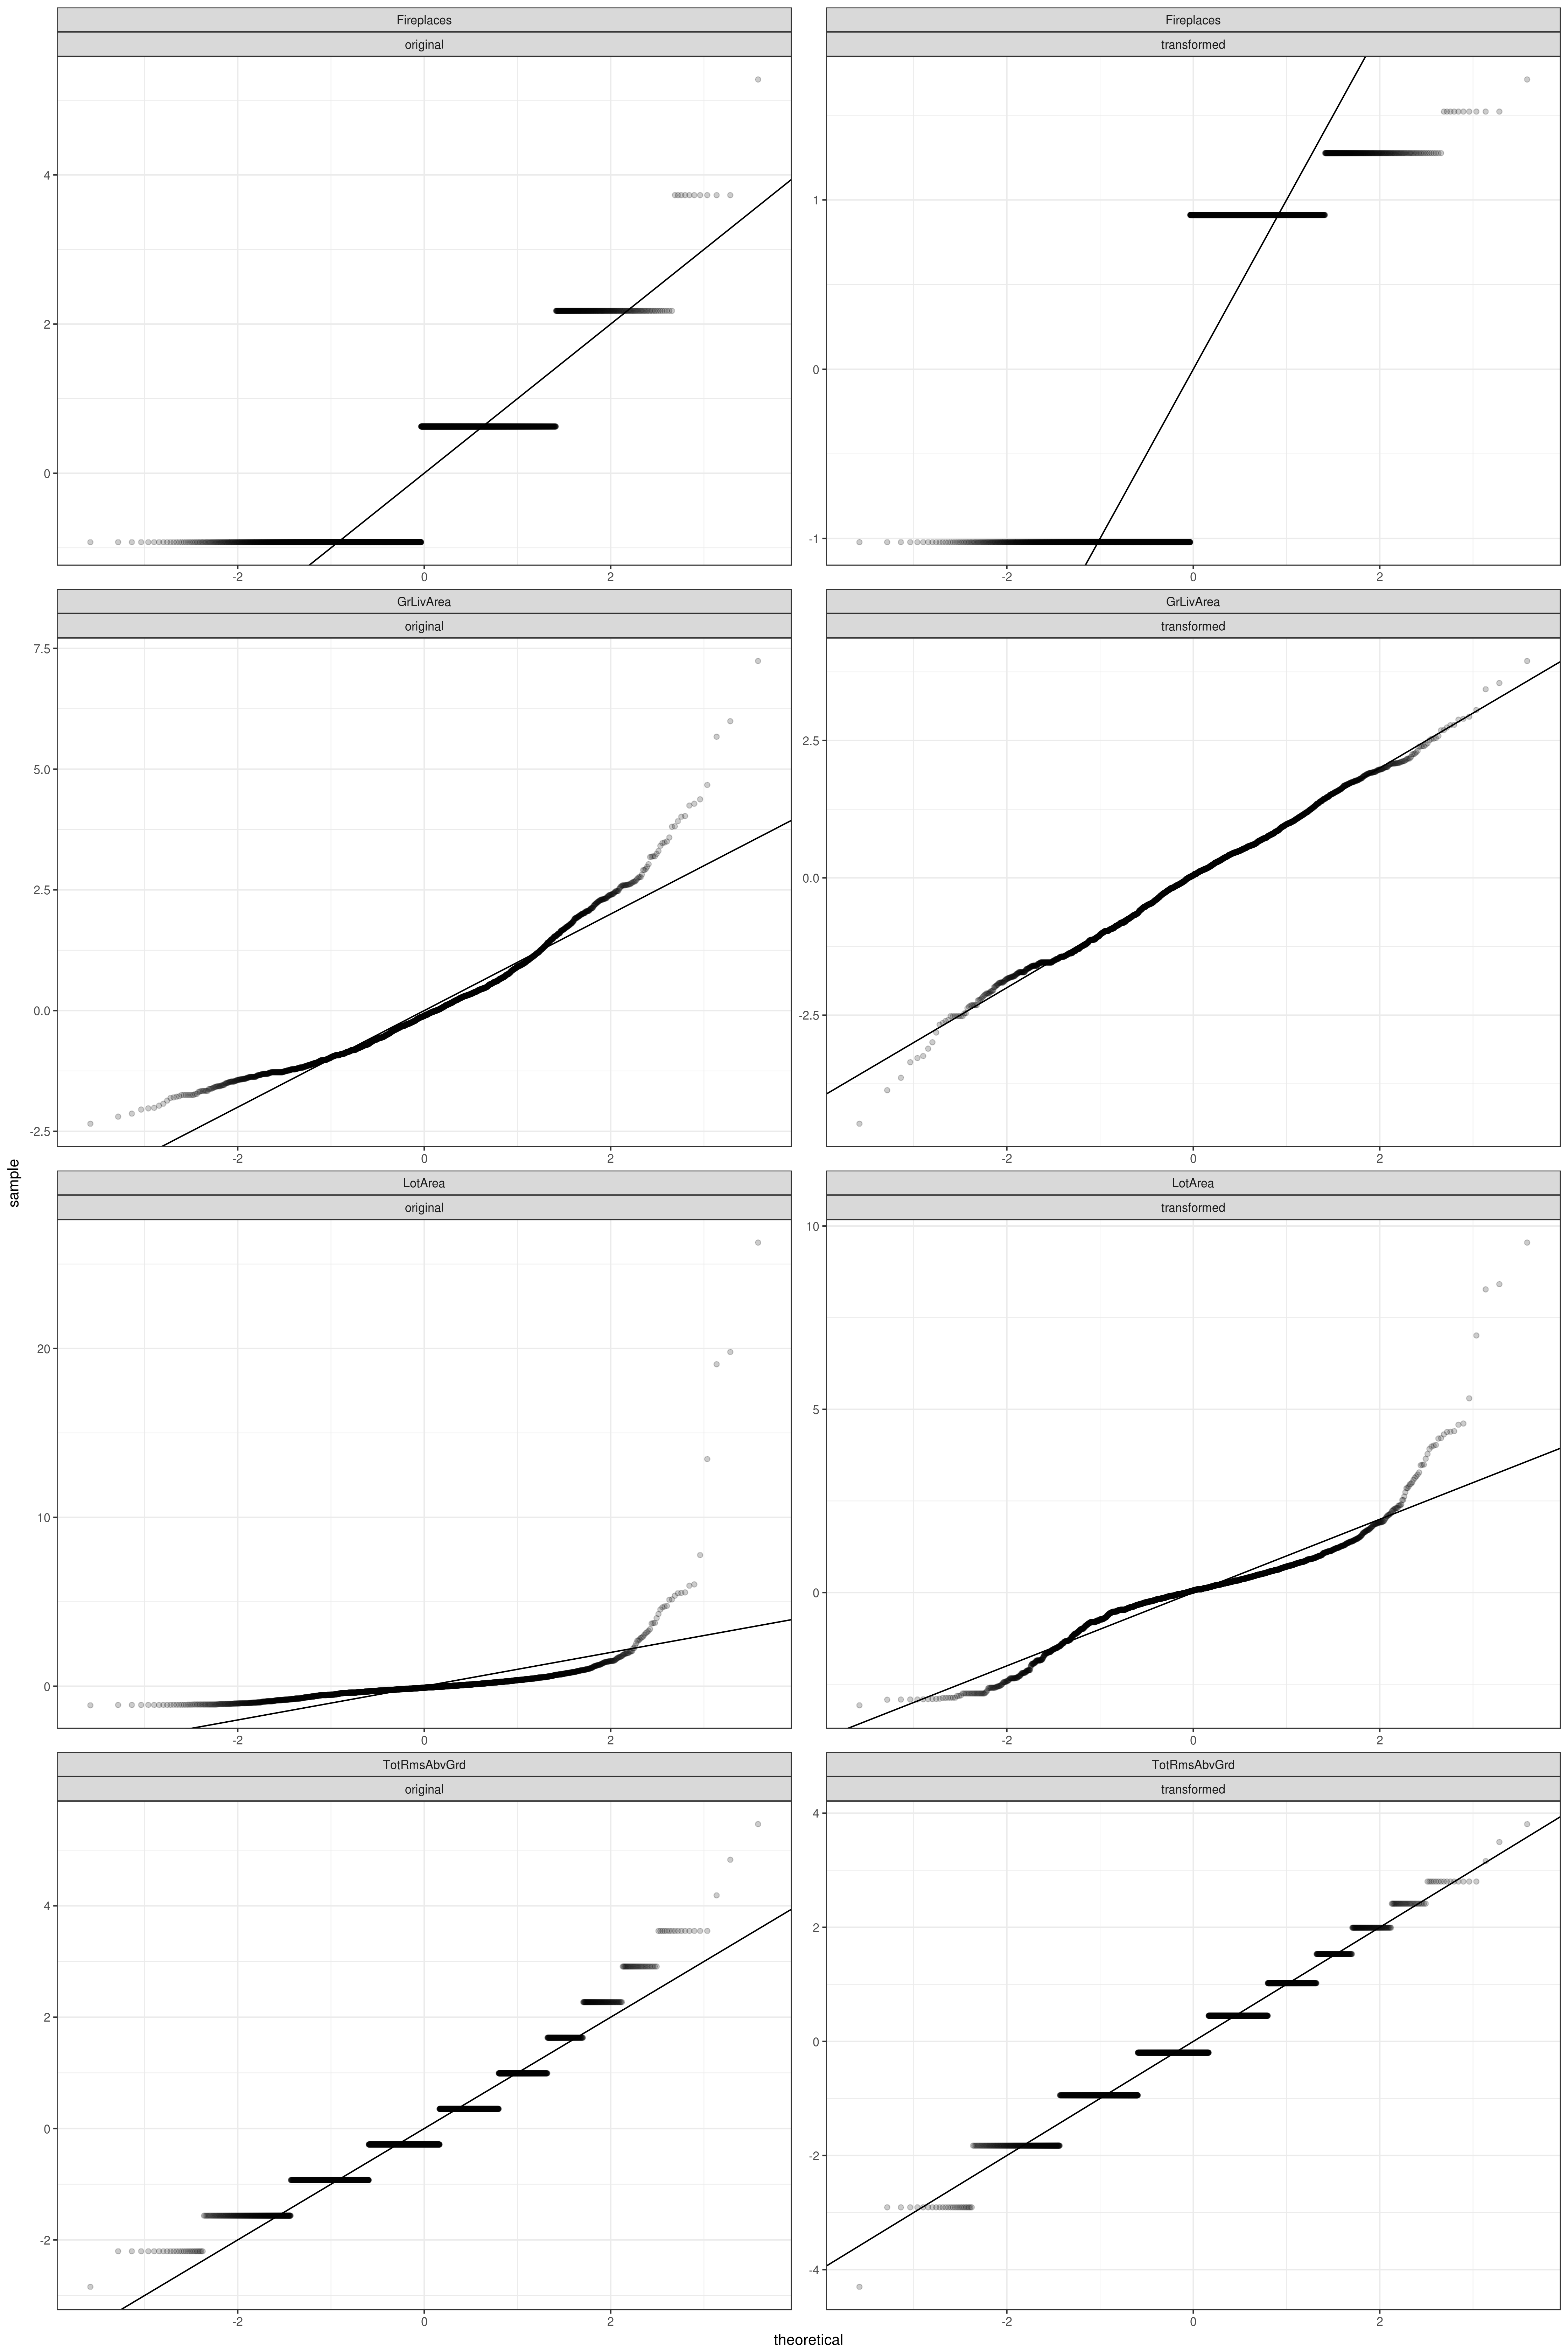

In [10]:
df <- num_tran$Tran$for_qq_plot(
    combinedDataset, 
    transformation_config3
)

options(repr.plot.width = 16, repr.plot.height = 24, repr.plot.res=280)

df %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(var~tran, ncol=2, scales="free") +
geom_abline(slope=1) +
theme_bw()

In [12]:
transformed_dataset <-
    num_tran$functional_transform(combinedDataset, transformation_config3)

test_that("GrLivArea", {
    expect_equal(
        transformed_dataset$GrLivArea, 
        log(combinedDataset$GrLivArea + 1)
    )
})

test_that("LotArea", {
    expect_equal(
        transformed_dataset$LotArea, 
        (combinedDataset$LotArea)**(1/4)
    )
})

test_that("categ var are intact", {
    expect_equal(
        transformed_dataset %>% select_if(is.character), 
        combinedDataset %>% select_if(is.character)
    )
})

test_that("numeric vars not included in transformation config are intact", {
    expect_equal(
        transformed_dataset %>% select_if(is.numeric) %>% select(-one_of(transformation_config3$var)), 
        combinedDataset %>% select_if(is.numeric) %>% select(-one_of(transformation_config3$var))
    )
})